# [ ~ Download and Pickle Weather Data~ ]

In [2]:
#Download NEXRAD Data 
#Store output on local machine after first run, takes a long time
import pyart
import fsspec
#from metpy.plots import UtSCOUNTIES
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pickle


fs = fsspec.filesystem("s3", anon=True)
files = sorted(fs.glob("s3://noaa-nexrad-level2/2022/06/02/KHGX/KHGX20220602_18*"))
radar = pyart.io.read_nexrad_archive(f's3://{files[3]}')
list(radar.fields)

['cross_correlation_ratio',
 'differential_phase',
 'differential_reflectivity',
 'spectrum_width',
 'clutter_filter_power_removed',
 'reflectivity',
 'velocity']

In [4]:
#send to a pickled file once appropriate data is deterimined
with open('weatherdat.pickle', 'wb') as handle:
    pickle.dump(radar, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [5]:
import numpy as np
import tensorflow as tf
import keras
import cv2
from keras.models import Sequential
from keras.preprocessing.image import img_to_array
import os
from tqdm import tqdm
import re
import pickle
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'tensorflow'

# [ ~ Load Weather Data From Pickle ~ ]

In [22]:
with open("weatherdat.pickle", "rb") as f:
    l = pickle.load(f)

In [23]:
print(list(l.fields))
l = np.array(l)

['cross_correlation_ratio', 'differential_phase', 'differential_reflectivity', 'spectrum_width', 'clutter_filter_power_removed', 'reflectivity', 'velocity']


In [24]:
np.random.shuffle(l)

TypeError: len() of unsized object

In [12]:
def mean_conv(img):
    size = 6
    stride = 5
    ret = np.ones((3,3))
    stx=0
    for i in range(3):
        sty = 0
        for j in range(3):
            ret[i][j] = np.mean(img[stx:stx+size, sty:sty+size])
            sty += stride
        stx += stride
    
    return ret

In [13]:
SIZE = 16
high_img = []
for i in tqdm(range(len(l))):
    img = l[i]
    img[np.isnan(img)]=np.mean(img[~np.isnan(img)])    
    #resizing image
    img = cv2.resize(img, (SIZE, SIZE))
    high_img.append(img)
temp_img = []
low_img = []
for i in tqdm(range(len(l))):
    img = l[i]
    img[np.isnan(img)]=np.mean(img[~np.isnan(img)])    
    #resizing image
    img = cv2.resize(img, (SIZE, SIZE))
    temp = mean_conv(img)
    temp_img.append(temp)
    img = cv2.resize(temp, (SIZE, SIZE), interpolation=cv2.INTER_NEAREST)
    low_img.append(img)

NameError: name 'tqdm' is not defined

# Data Visualization

IndexError: list index out of range

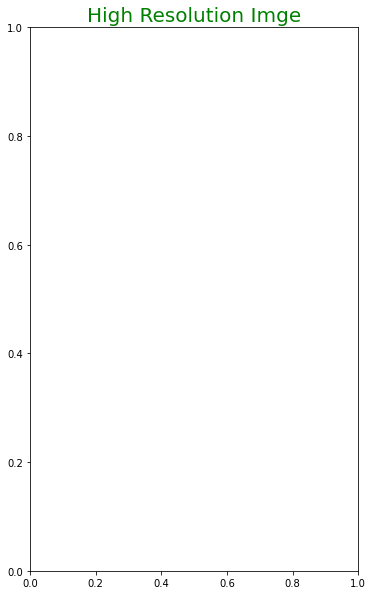

In [14]:
for i in range(4):
    a = np.random.randint(0,3600)
    plt.figure(figsize=(20,10))
    plt.subplot(1,3,1)
    plt.title('High Resolution Imge', color = 'green', fontsize = 20)
    plt.imshow(high_img[a])
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.title('low Resolution Image ', color = 'black', fontsize = 20)
    plt.imshow(low_img[a])
    plt.axis('off')
    plt.subplot(1,3,3)
    plt.title('temp Resolution Image ', color = 'black', fontsize = 20)
    plt.imshow(temp_img[a])
    plt.axis('off')

# Slicing and Reshaping Images

In [15]:
train_high_image = high_img[:2304]
train_low_image = low_img[:2304]
train_high_image = np.reshape(train_high_image,(len(train_high_image),SIZE,SIZE,1))
train_low_image = np.reshape(train_low_image,(len(train_low_image),SIZE,SIZE,1))

validation_high_image = high_img[2304:2880]
validation_low_image = low_img[2304:2880]
validation_high_image= np.reshape(validation_high_image,(len(validation_high_image),SIZE,SIZE,1))
validation_low_image = np.reshape(validation_low_image,(len(validation_low_image),SIZE,SIZE,1))


test_high_image = high_img[2880:]
test_low_image = low_img[2880:]
test_high_image= np.reshape(test_high_image,(len(test_high_image),SIZE,SIZE,1))
test_low_image = np.reshape(test_low_image,(len(test_low_image),SIZE,SIZE,1))

print("Shape of training images:",train_high_image.shape)
print("Shape of test images:",test_high_image.shape)
print("Shape of validation images:",validation_high_image.shape)


NameError: name 'low_img' is not defined

# DeepSD Conversion Into TFRecord

# DeepSD Training
(from https://github.com/tjvandal/deepsd/)

In [ ]:
import os
import time
import sys
import datetime as dt
import re

import numpy as np
import tensorflow as tf
import ConfigParser

base_srcnn = os.path.join(os.path.dirname(os.path.abspath(__file__)), 'srcnn-tensorflow')
sys.path.append(base_srcnn)
from srcnn import srcnn
from tfreader import inputs_climate


flags = tf.flags
flags.DEFINE_string('config_file', 'config.ini', 'Configuration file with [SRCNN] section.')
flags.DEFINE_string('checkpoint_file', None, 'Any checkpoint with the same architecture as'\
                    'configured.')
flags.DEFINE_string('model_number', '1', 'Experiment-? in config file/')

# parse flags
FLAGS = flags.FLAGS
FLAGS._parse_flags()



## READ CONFIGURATION FILE
config = ConfigParser.ConfigParser()
config.read(FLAGS.config_file)

LAYER_SIZES = [int(k) for k in config.get('SRCNN', 'layer_sizes').split(",")]
KERNEL_SIZES = [int(k) for k in config.get('SRCNN', 'kernel_sizes').split(",")]
OUTPUT_DEPTH = LAYER_SIZES[-1]
AUX_DEPTH = int(config.get('SRCNN', 'aux_depth'))
LEARNING_RATE = float(config.get('SRCNN', 'learning_rate'))
TRAINING_ITERS = int(config.get('SRCNN', 'training_iters'))
BATCH_SIZE = int(config.get('SRCNN', 'batch_size'))
TRAINING_INPUT_SIZE = int(config.get('SRCNN', 'training_input_size'))
INPUT_DEPTH = int(config.get('SRCNN', 'training_input_depth'))
SAVE_STEP = int(config.get('SRCNN', 'save_step'))
TEST_STEP = int(config.get('SRCNN', 'test_step'))
KEEP_PROB = 1. - float(config.get('SRCNN', 'dropout_prob'))

# where to save and get data
DATA_DIR = config.get('Model-%s' % FLAGS.model_number, 'data_dir')
MODEL_NAME = config.get('Model-%s' % FLAGS.model_number, 'model_name')
timestamp = str(int(time.time()))
curr_time = dt.datetime.now()

SAVE_DIR = os.path.join(config.get('SRCNN', 'scratch'), "srcnn_%s_%s_%s" % ( MODEL_NAME,
                    '-'.join([str(s) for s in LAYER_SIZES]),
                    '-'.join([str(s) for s in KERNEL_SIZES])))

if not os.path.exists(SAVE_DIR):
    os.mkdir(SAVE_DIR)

def train():
    with tf.Graph().as_default(), tf.device("/cpu:0"):
        global_step = tf.get_variable('global_step', [],
                    initializer=tf.constant_initializer(0), trainable=False)

        errors = []

        # lets get data to iterate through
        lr_size = int(TRAINING_INPUT_SIZE / 2)
        train_images, train_labels = inputs_climate(BATCH_SIZE, TRAINING_ITERS,
                        DATA_DIR, lr_shape=[lr_size, lr_size], lr_d=INPUT_DEPTH,
                        aux_d=AUX_DEPTH, is_training=True,
                        hr_shape=[TRAINING_INPUT_SIZE, TRAINING_INPUT_SIZE], hr_d=OUTPUT_DEPTH)
        test_images, test_labels, test_times = inputs_climate(BATCH_SIZE, TRAINING_ITERS,
                        DATA_DIR, is_training=False, lr_d=INPUT_DEPTH, aux_d=1,
                        hr_d=OUTPUT_DEPTH)

        # crop training labels
        border_size = (sum(KERNEL_SIZES) - len(KERNEL_SIZES))/2
        train_labels_cropped = train_labels[:,border_size:-border_size,border_size:-border_size,:]

        # set placeholders
        is_training = tf.placeholder_with_default(True, (), name='is_training')

        x = tf.cond(is_training, lambda: train_images, lambda: test_images)
        y = tf.cond(is_training, lambda: train_labels_cropped, lambda: test_labels)

        x = tf.identity(x, name='x')
        y = tf.identity(y, name='y')

        # Use SRCNN
        model = srcnn.SRCNN(x, y, LAYER_SIZES, KERNEL_SIZES, input_depth=INPUT_DEPTH,
                            learning_rate=LEARNING_RATE, upscale_factor=2,
                           is_training=is_training, gpu=True)
        prediction = tf.identity(model.prediction, name='prediction')

        # initialize graph and start session
        saver = tf.train.Saver()
        init = tf.global_variables_initializer()
        sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                log_device_placement=False))
        sess.run(init)
        sess.run(tf.local_variables_initializer())

        # look for checkpoint
        if FLAGS.checkpoint_file is not None:
            try:
                checkpoint = tf.train.latest_checkpoint(FLAGS.checkpoint_file)
                saver.restore(sess, checkpoint)
                print("Checkpoint", checkpoint)
            except tf.errors.InternalError as err:
                print("Warning: Could not find checkpoint", err)
                pass

        # start coordinator for data
        coord = tf.train.Coordinator()
        threads = tf.train.start_queue_runners(sess=sess, coord=coord)

        # summary data
        summary_op = tf.summary.merge_all()
        train_writer = tf.summary.FileWriter(SAVE_DIR + '/train', sess.graph)
        test_writer = tf.summary.FileWriter(SAVE_DIR + '/test', sess.graph)

        def feed_dict(train=True):
            return {is_training: train}

        #curr_step = int(sess.run(model.global_step))
        curr_step = 0
        for step in range(curr_step, TRAINING_ITERS+1):
            start_time = time.time()
            _, train_loss, train_rmse = sess.run([model.opt, model.loss, model.rmse],
                                                 feed_dict=feed_dict(True))
            duration = time.time() - start_time
            if step  % TEST_STEP == 0:
                test_summary = sess.run(summary_op, feed_dict=feed_dict(True))
                train_writer.add_summary(test_summary, step)

                d = feed_dict(train=True)
                out = sess.run([model.loss, model.rmse, summary_op, model.x_norm], feed_dict=d)
                test_writer.add_summary(out[2], step)
                print("Step: %d, Examples/sec: %0.5f, Training Loss: %2.3f," \
                        " Train RMSE: %2.3f, Test RMSE: %2.4f" % \
                        (step, BATCH_SIZE/duration, train_loss, train_rmse, out[1]))

            if step % SAVE_STEP == 0:
                save_path = saver.save(sess, os.path.join(SAVE_DIR, "srcnn.ckpt"))

        save_path = saver.save(sess, os.path.join(SAVE_DIR, "srcnn.ckpt"))

train()

# Defining Model

In [17]:
from keras import layers
def down(filters , kernel_size, apply_batch_normalization = True):
    downsample = tf.keras.models.Sequential()
    downsample.add(layers.Conv2D(filters,kernel_size,padding = 'same', strides = 2))
    if apply_batch_normalization:
        downsample.add(layers.BatchNormalization())
    downsample.add(keras.layers.LeakyReLU())
    return downsample


def up(filters, kernel_size, dropout = False):
    upsample = tf.keras.models.Sequential()
    upsample.add(layers.Conv2DTranspose(filters, kernel_size,padding = 'same', strides = 2))
    if dropout:
        upsample.dropout(0.2)
    upsample.add(keras.layers.LeakyReLU())
    return upsample

def model():
    inputs = layers.Input(shape= [SIZE,SIZE,1])
    d1 = down(128,(3,3),False)(inputs)
    d2 = down(128,(3,3),False)(d1)
    d3 = down(256,(3,3),True)(d2)
    d4 = down(512,(3,3),True)(d3)
    
    #upsampling
    u2 = up(256,(3,3),False)(d4)
    u2 = layers.concatenate([u2,d3])
    u3 = up(128,(3,3),False)(u2)
    u3 = layers.concatenate([u3,d2])
    u4 = up(128,(3,3),False)(u3)
    u4 = layers.concatenate([u4,d1])
    u5 = up(3,(3,3),False)(u4)
    u5 = layers.concatenate([u5,inputs])
    output = layers.Conv2D(1,(2,2),strides = 1, padding = 'same')(u5)
    return tf.keras.Model(inputs=inputs, outputs=output)


model = model()
model.summary()

# Compile 

In [21]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), loss = 'mean_absolute_error',
              metrics = ['acc'])

# Fitting model

In [22]:
model.fit(train_low_image, train_high_image, epochs = 40, batch_size = 16,
          validation_data = (validation_low_image,validation_high_image))

# Prediction Visualization

In [20]:
def plot_images(high,low,predicted):
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.title('High Image', color = 'green', fontsize = 20)
    plt.imshow(high)
    plt.subplot(1,3,2)
    plt.title('Low Image ', color = 'black', fontsize = 20)
    plt.imshow(low)
    plt.subplot(1,3,3)
    plt.title('Predicted Image ', color = 'Red', fontsize = 20)
    plt.imshow(predicted)
   
    plt.show()

for i in range(100,110):
    
    predicted = np.clip(model.predict(test_low_image[i].reshape(1,SIZE, SIZE,1)),0.0,1.0).reshape(SIZE, SIZE,1)
    plot_images(test_high_image[i],test_low_image[i],predicted)

# Saving model

In [9]:
model.save("final_model.h5")

## Thank You !!!